In [1]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

sys.path.append('..')
%autoreload 2
from common.analysis import plot_ac_exp

from IPython.display import display
%matplotlib inline

In [2]:
def sweep_summary(root):
    configs = {}
    all_summary = []
    for d in glob(f'{root}/*/'):
        eval_f = f'{d}/eval.csv'
        try:
            eval_df = pd.read_csv(eval_f)
        except:
            continue
        print
#         last_eval_rew = eval_df.episode_reward.values[-10:].mean()
        last_eval_rew = eval_df.episode_reward.values[-1]
        best_eval_rew = eval_df.episode_reward.values.max()
        fname = f'{d}/config.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/config.yaml'
            assert os.path.exists(fname)
        config = OmegaConf.load(fname)
        configs[d] = config
        fname = f'{d}/overrides.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/overrides.yaml'
            assert os.path.exists(fname)
        overrides = OmegaConf.load(fname)
        summary = dict(x.split('=') for x in overrides)
        summary['best_eval_rew'] = best_eval_rew
        summary['last_eval_rew'] = last_eval_rew
        summary['d'] = d
        summary['env_name'] = config.env_name
        all_summary.append(summary)
    
    if len(all_summary) == 0:
        print('No experiments with eval data found.')
        return [None]*4
        
    all_summary = pd.DataFrame(all_summary)
    for col in all_summary.columns:
        if col != 'env_name' and len(all_summary[col].unique()) == 1:
            all_summary.drop(col,inplace=True,axis=1)

    filt = ['env_name', 'seed']
    groups = [x.split('=')[0] for x in overrides]
    groups = [x for x in groups if x not in filt]
    groups = list(set(groups) & set(all_summary.columns))
    groups = ['env_name'] + groups
    groups = all_summary.groupby(groups)
    agg = groups.agg(['mean', 'std'])

    return all_summary, groups, agg, configs

def plot_rew(root, ax=None, label=None):
    if ax is None:
        nrow, ncol = 1, 1
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
        ax.set_xlabel('1k Updates')
    
    try:
        eval_df = pd.read_csv(f'{root}/eval.csv')
    except:
        return
    l, = ax.plot(eval_df.step/1000, eval_df.episode_reward, label=label)

def plot_rew_list(ds, title=None, ax=None):
    nrow, ncol = 1, 1
    if ax is None:
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
#     ax.set_ylim(0, 1000)
    if title is not None:
        ax.set_title(title)
    for d in ds:
        label = d.split('/')[-2]
        plot_rew(d, ax=ax, label=label)
    ax.legend()

def plot_all_rew(root):
    nrow, ncol = 1, 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
    title = '/'.join(root.split('/')[-3:])
    ax.set_title(title)
#     ax.set_ylim(0, 1000)
    for d in glob(f'{root}/*/'):
        label = d.split('/')[-2]
        plot_rew(d, fig=fig, label=label)
    ax.legend()

def plot_agg(df, agg, ncol=4):
    nrow = int(np.ceil(len(agg)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    if nrow == 1 and ncol == 1:
        axs = [axs]
    else:
        axs = axs.ravel()
    for ax, (r, sub_df) in zip(axs, agg.iterrows()):
        if isinstance(r, str):
            r = [r]
        I = df.index == df.index
        for k, v in zip(agg.index.names, r):
            I = I & (df[k] == v)
        df_I = df[I]
        title = '.'.join([f'{k}={v}' for k,v in zip(agg.index.names, r)])
        title = title.replace('agent.params.', '').replace('model.params.', '')
        title = '\n'.join(textwrap.wrap(title, 45))
        plot_rew_list(df_I.d.values, title=title, ax=ax)
    fig.tight_layout()

def plot_ablation(
    groups, title, xmax=None,
    save=None, lw=3,
    xlabel='Timestep', ylabel='Reward',
    legend=False, sac_lim=None
):
    fig, ax = plt.subplots(1, 1, figsize=(4.5,3))

    for group in groups:
        all_df = []
        min_step = None
        for root in group['roots']:
            eval_f = f'{root}/eval.csv'
            df = pd.read_csv(eval_f)
            if min_step is None or max(df['step']) < min_step:
                min_step = max(df['step'])
            df['f'] = eval_f
            all_df.append(df)

        step_interp = np.linspace(0, min_step, num=20)
        all_df_interp = []
        for df in all_df:
            rew_interp = np.interp(step_interp, df['step'], df['episode_reward'])
            df_interp = pd.DataFrame({'step': step_interp, 'rew': rew_interp})
            all_df_interp.append(df_interp)
        all_df_interp = pd.concat(all_df_interp)
        label = group['tag'] if legend else None
        if 'color' in group:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label, color=group['color'])
        else:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label)
                
    ax.axhline(sac_lim, lw=lw, linestyle='--', color='k')

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xmax is not None:
        ax.set_xlim(0, xmax)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(save)
        os.system(f'convert -trim {save} {save}')

best_eval_rew            last_eval_rew  \
                                        mean        std          mean   
env_name      obs_enc                                                   
mbpo_walker2d proprio_MLP        5297.791155  466.89308   4925.237811   
              proprio_identity   5753.981348  509.66195   5284.118690   

                                            
                                       std  
env_name      obs_enc                       
mbpo_walker2d proprio_MLP       796.997315  
              proprio_identity  490.111630

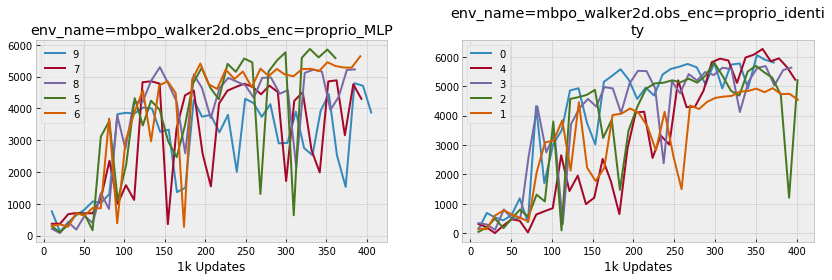

In [3]:
d = '../exp/2020.03.05/1620_sac_mve_walker_enc/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

KeyError: 'critic_Q_loss'

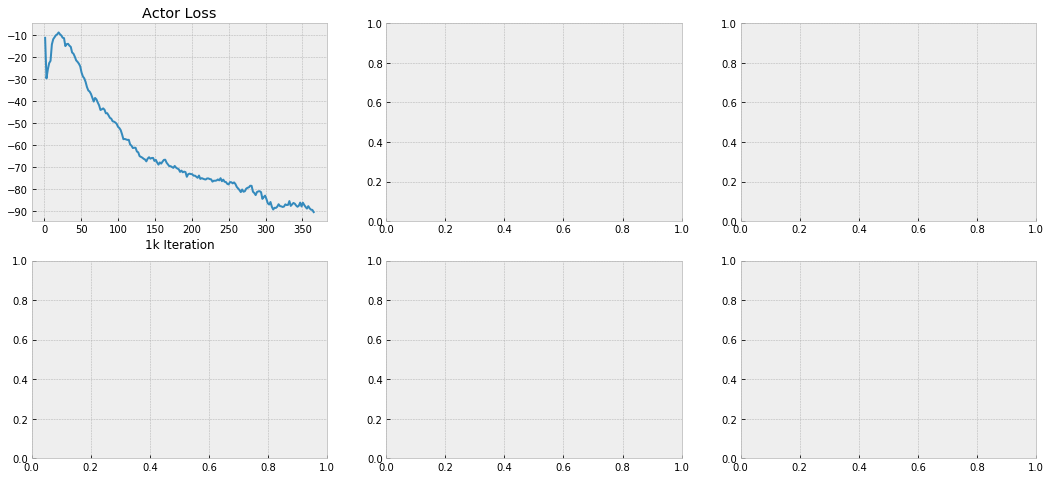

In [ ]:
d = '../exp/2020.03.10/1237_sac_mve_walker_enc_MLP/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=4)

In [ ]:
d = '../exp/2020.03.12/1440_sac_mve_walker_enc_MLP/'
all_summary, groups, agg, configs = sweep_summary(d)
display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=1)

best_eval_rew             last_eval_rew  \
                                     mean         std          mean   
env_name      env                                                     
mbpo_ant      mbpo_ant        8228.888545  678.425975   8181.565566   
mbpo_cheetah  mbpo_cheetah   15444.379813  518.602455  14969.617593   
mbpo_hopper   mbpo_hopper     3797.811469   90.471282   3690.394469   
mbpo_humanoid mbpo_humanoid   7702.347071  677.665838   7396.954240   
mbpo_walker2d mbpo_walker2d   5611.831024  154.343506   5447.073522   

                                         
                                    std  
env_name      env                        
mbpo_ant      mbpo_ant       706.638879  
mbpo_cheetah  mbpo_cheetah   665.121303  
mbpo_hopper   mbpo_hopper    155.933239  
mbpo_humanoid mbpo_humanoid  426.023948  
mbpo_walker2d mbpo_walker2d  202.446126

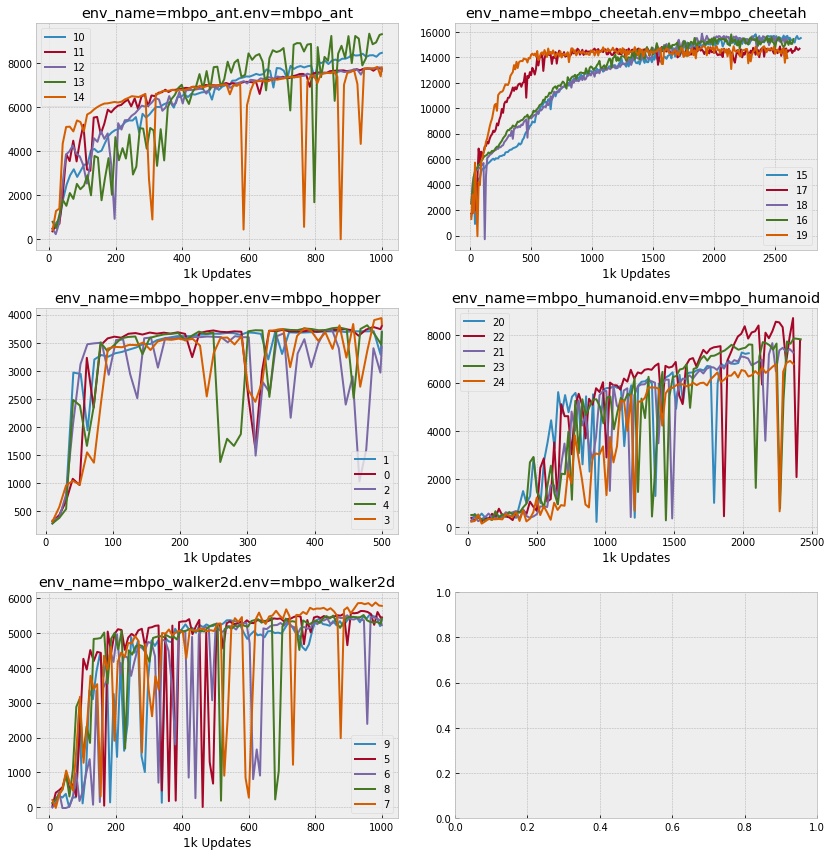

In [5]:
d = '../exp/2020.03.16/1851_sac_mve_mbpo/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

best_eval_rew             last_eval_rew  \
                                     mean         std          mean   
env_name      env                                                     
mbpo_ant      mbpo_ant        9443.500056  864.271340   9043.029694   
mbpo_humanoid mbpo_humanoid   5739.418201  448.026909   5713.662947   

                                          
                                     std  
env_name      env                         
mbpo_ant      mbpo_ant       1180.595655  
mbpo_humanoid mbpo_humanoid   454.511003

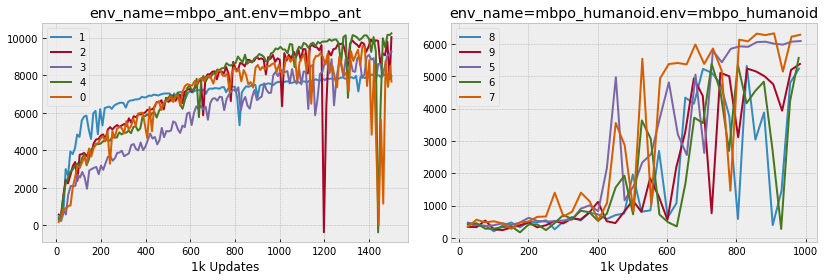

In [8]:
d = '../exp/2020.03.22/1943_sac_mve_mbpo/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

best_eval_rew              last_eval_rew  \
                                     mean          std          mean   
env_name      env                                                      
mbpo_ant      mbpo_ant        7741.458763   540.866143   7643.102193   
mbpo_cheetah  mbpo_cheetah   13004.432053  5813.156686  12850.868841   
mbpo_hopper   mbpo_hopper     3956.653599   142.464556   3256.301220   
mbpo_humanoid mbpo_humanoid   5529.351404   233.426202   4517.255397   
mbpo_walker2d mbpo_walker2d   5843.412951   121.405575   5610.281525   

                                          
                                     std  
env_name      env                         
mbpo_ant      mbpo_ant        616.631485  
mbpo_cheetah  mbpo_cheetah   5738.877082  
mbpo_hopper   mbpo_hopper     629.298754  
mbpo_humanoid mbpo_humanoid  1833.100721  
mbpo_walker2d mbpo_walker2d   252.910184

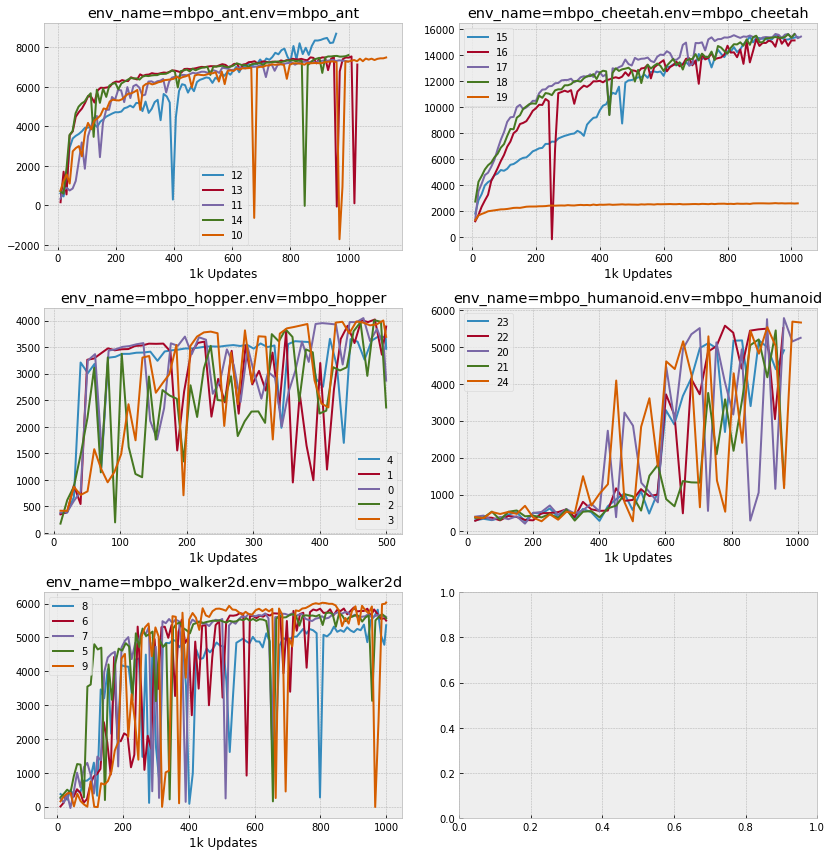

In [14]:
d = '../exp/2020.03.27/2011_sac_mve_mbpo/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)

best_eval_rew              last_eval_rew  \
                                     mean          std          mean   
env_name      env                                                      
mbpo_ant      mbpo_ant        7123.629925  2079.377386   6992.953162   
mbpo_cheetah  mbpo_cheetah   14240.924546  2428.383574  13935.009754   
mbpo_hopper   mbpo_hopper     3830.934088   205.367034   3408.638359   
mbpo_humanoid mbpo_humanoid   5813.850322   465.284489   5667.811232   
mbpo_walker2d mbpo_walker2d   5693.927315   356.623941   5148.653486   

                                          
                                     std  
env_name      env                         
mbpo_ant      mbpo_ant       1981.638328  
mbpo_cheetah  mbpo_cheetah   2449.789707  
mbpo_hopper   mbpo_hopper     893.489809  
mbpo_humanoid mbpo_humanoid   429.516879  
mbpo_walker2d mbpo_walker2d   628.064109

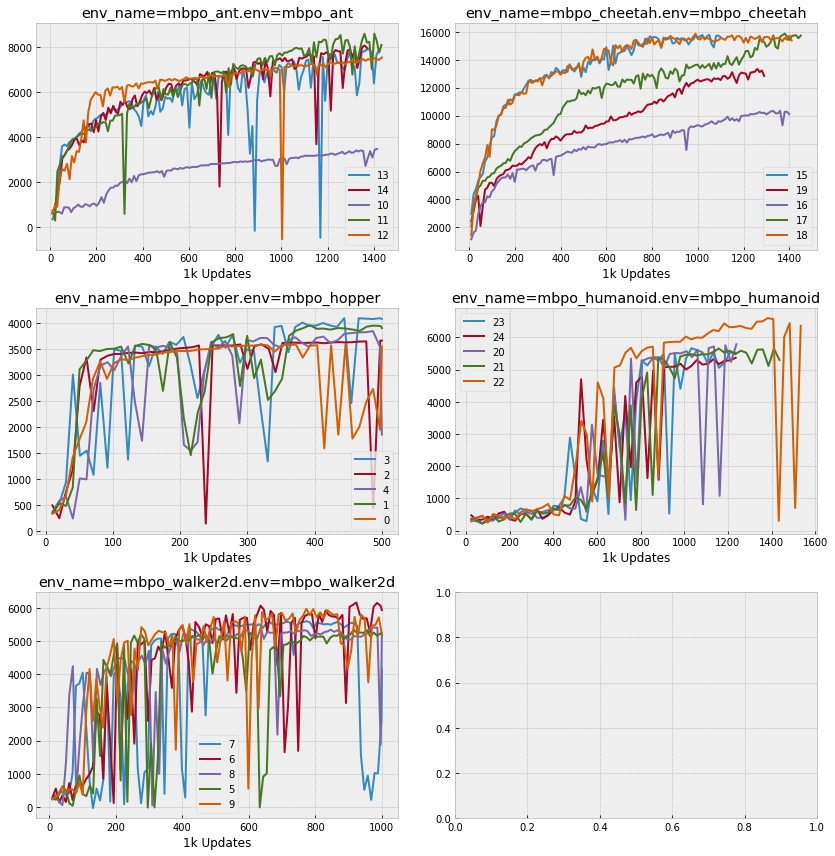

In [15]:
d = '../exp/2020.03.28/0852_sac_mve_mbpo-less-model-updates/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
display(agg)
plot_agg(all_summary, agg, ncol=2)